# Measure skew-spectra of DM in redshift space --version 2#

In [4]:
from __future__ import print_function, division


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from nbodykit import style

import matplotlib.pyplot as plt
import numpy as np
import os

from lsstools.cosmo_model import CosmoModel
from lsstools.gen_cosmo_fcns import calc_f_log_growth_rate, generate_calc_Da
from lsstools.model_spec import get_trf_spec_from_list
from lsstools.paint_utils import mass_weighted_paint_cat_to_delta
from lsstools.results_db import retrieve_pickles
from lsstools.results_db.io import Pickler
from perr.path_utils import get_in_path
from lsstools.nbkit03_utils import get_csum, get_csqsum, apply_smoothing, catalog_persist, get_cstats_string, linear_rescale_fac, get_crms,convert_nbk_cat_to_np_array
from perr_private.model_target_pair import ModelTargetPair, Model, Target
from lsstools.sim_galaxy_catalog_creator import SimGalaxyCatalogCreator, PTChallengeGalaxiesFromRockstarHalos
from perr_private.read_utils import readout_mesh_at_cat_pos


#from nbodykit.lab import ArrayCatalog, BigFileMesh


plt.style.use(style.notebook)
colors = [d['color'] for d in style.notebook['axes.prop_cycle']]

## Global params ##

In [5]:
# path
sim_seed = 400
boxsize = 1500.0
basedir = '/Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000%d-01536-%.1f-wig/' % (sim_seed, boxsize)
theo_basedir = '../data/azadeh_08sep2020/'
sim_scale_factor = 0.625

Rsmooth = 20.
Ngrid = 64

LOS = np.array([0,0,1])

# actually apply RSD or not
APPLY_RSD = False


# cosmology of ms_gadget sims (to compute D_lin(z))
# omega_m = 0.307494
# omega_bh2 = 0.022300
# omega_ch2 = 0.118800
# h = math.sqrt((omega_bh2 + omega_ch2) / omega_m) = 0.6774
cosmo_params = dict(Om_m=0.307494,
                   Om_L=1.0 - 0.307494,
                   Om_K=0.0,
                   Om_r=0.0,
                   h0=0.6774)

f_log_growth = np.sqrt(0.61826)

# Smoothings in lagrangian space, in Mpc/h
#Rsmooth_density_to_shift = 0.0   # 0.0 before 30/3/2020
#Rsmooth_displacement_source = 0.23   # 0.23 before 30/3/2020

# Options for shifted field
#ShiftedFieldsNp = 1536
#ShiftedFieldsNmesh = 1536

# avg or sum. Should use avg to get correct velocity model.
#PsiDot_weighted_CIC_mode = 'avg'


# Below, 'D' stands for RSD displacement in Mpc/h: D=v/(aH)=f*PsiDot.
tex_names = {}

## Targets
# RSD displacement of DM subsample
DM_subsample = Target(
    name='DM_subsample',
    in_fname=os.path.join(basedir, 'snap_%.4f_sub_sr0.0015_ssseed40%d.bigfile' % (sim_scale_factor, sim_seed)),
    position_column='Position'
)

DM_D2 = Target(
    name='DM_D2',
    in_fname=os.path.join(basedir, 'snap_%.4f_sub_sr0.0015_ssseed40%d.bigfile' % (sim_scale_factor, sim_seed)),
    position_column='Position',
    val_column='Velocity',
    val_component=2,
    rescale_factor='RSDFactor'
)


# PT Challenge galaxies from rockstar halos. Rockstar gives core positions and velocities.
# Units: 1/(aH) = 1./(a * H0*np.sqrt(Om_m/a**3+Om_L)) * (H0/100.) in Mpc/h / (km/s).
# For ms_gadget, get 1/(aH) = 0.01145196 Mpc/h/(km/s) = 0.0183231*0.6250 Mpc/h/(km/s).
# Note that MP-Gadget files have RSDFactor=1/(a^2H)=0.0183231 for a=0.6250 b/c they use a^2\dot x for Velocity.
assert sim_scale_factor == 0.625

# subbox of PT challenge galaxies, apply RSD to position (TEST)

assert sim_scale_factor == 0.625
gal_ptchall_with_RSD = Target(
    name='gal_ptchall_with_RSD',
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.parents.bigfile' % sim_scale_factor),
    position_column='Position',
    velocity_column='Velocity', 
    apply_RSD_to_position=True,
    RSD_los=LOS,
    RSDFactor=0.01145196,
    #val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    #val_component=0,
    #rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
    cuts=[PTChallengeGalaxiesFromRockstarHalos(
            log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False),
          #('Position', 'max', [100.,100.,20.])
         ]
    )

# subbox of PT challenge galaxies, y component
assert sim_scale_factor == 0.625
gal_ptchall_subbox_D1 = Target(
    name='gal_ptchall_D1',
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.parents.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    val_component=1,
    rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
    cuts=[PTChallengeGalaxiesFromRockstarHalos(
            log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False),
          ('Position', 'max', [500.,500.,20.])
         ]
    )


In [6]:
### Models for density

z_rescalefac = linear_rescale_fac(current_scale_factor=1.0,
                                  desired_scale_factor=sim_scale_factor,
                                  cosmo_params=cosmo_params)
print('z_rescalefac:', z_rescalefac)
deltalin = Model(
    name='deltalin',
    in_fname=os.path.join(basedir, 'IC_LinearMesh_z0_Ng%d' % Ngrid),
    rescale_factor=z_rescalefac,
    read_mode='delta from 1+delta',
    filters=None,
    readout_window='cic')

# Linear RSD displacement
def k2ovksq_filter_fcn(k, v, d=2):
    ksq = sum(ki**2 for ki in k)
    return np.where(ksq == 0.0, 0*v, 1j*k[d] * v / (ksq))
deltalin_D2 = Model(
    name='deltalin_D2',
    in_fname=os.path.join(basedir, 'IC_LinearMesh_z0_Ng%d' % Ngrid),
    rescale_factor=f_log_growth*z_rescalefac,
    read_mode='delta from 1+delta',
    filters=[k2ovksq_filter_fcn],
    readout_window='cic')


z_rescalefac: 0.7336055475440896


## Read and plot Azadeh theory ##

In [7]:
Ptheo = np.genfromtxt(os.path.join(theo_basedir, 'p_deltadelta.txt'), names=True)

In [8]:
Ptheo.dtype

dtype([('k', '<f8'), ('P_link', '<f8'), ('P_0k', '<f8'), ('P_2k', '<f8'), ('P_4k', '<f8')])

In [9]:
realnames = ['k'] + ['S%dp_lin' %d for d in range(1,15)]
Sn_real_theo = np.genfromtxt(os.path.join(theo_basedir, 'Sn_real_R%d.txt' % int(Rsmooth)), names=realnames)
Sn_rsd_theo = OrderedDict()
for ell in [0,2,4]:
    rsdnames = ['k'] + ['S%d' % d for d in range(1,15)]
    Sn_rsd_theo[(ell,)] = np.genfromtxt(os.path.join(theo_basedir, 'Sn_rsd_%d_R%d.txt' % (ell,int(Rsmooth))), names=rsdnames)
    print(Sn_rsd_theo[(ell,)].dtype.names)

NameError: name 'OrderedDict' is not defined

In [ ]:
print(Sn_real_theo.dtype.names)

In [ ]:
# plot Plin azadeh
# interp_lnPtheo_lnk = OrderedDict()
# interp_Ptheo_k = OrderedDict()
# for key in Ptheo.dtype.names:
#     if key == 'k':
#         continue
#     interp_lnPtheo_lnk[key] = interp1d(np.log(Ptheo['k']), np.log(Ptheo[key]))
#     interp_Ptheo_k[key] = lambda k: np.exp(interp_lnPtheo_lnk[key](np.log(k)))
    
interp_lnPtheo_lnk_Plin = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_link']))
interp_Ptheo_k_Plin = lambda k: np.exp(interp_lnPtheo_lnk_Plin(np.log(k)))
interp_lnPtheo_lnk_P0 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_0k']))
interp_Ptheo_k_P0 = lambda k: np.exp(interp_lnPtheo_lnk_P0(np.log(k)))
interp_lnPtheo_lnk_P2 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_2k']))
interp_Ptheo_k_P2 = lambda k: np.exp(interp_lnPtheo_lnk_P2(np.log(k)))
interp_lnPtheo_lnk_P4 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_4k']))
interp_Ptheo_k_P4 = lambda k: np.exp(interp_lnPtheo_lnk_P4(np.log(k)))


# plot Plin
plt.subplots(figsize=(6,4))
plt.loglog(Ptheo['k'], Ptheo['P_link'], label='Plin')
kvec = np.logspace(-2,0,100)
plt.loglog(kvec, interp_Ptheo_k_Plin(kvec), 'r--')
plt.legend();
plt.ylabel('P'); plt.xlabel('k');

# Plot multipole power spectra azadeh
plt.subplots(figsize=(6,4))
for ell in [0,2,4]:
    plt.loglog(Ptheo['k'], Ptheo['k']**0*Ptheo['P_%dk' % ell], label='ell=%d'%ell)
    if ell==0:
        plt.loglog(kvec, interp_Ptheo_k_P0(kvec), 'r--')
    elif ell==2:
        plt.loglog(kvec, interp_Ptheo_k_P2(kvec), 'r--')
    elif ell==4:
        plt.loglog(kvec, interp_Ptheo_k_P4(kvec), 'r--')
plt.legend();
plt.ylabel('P'); plt.xlabel('k');




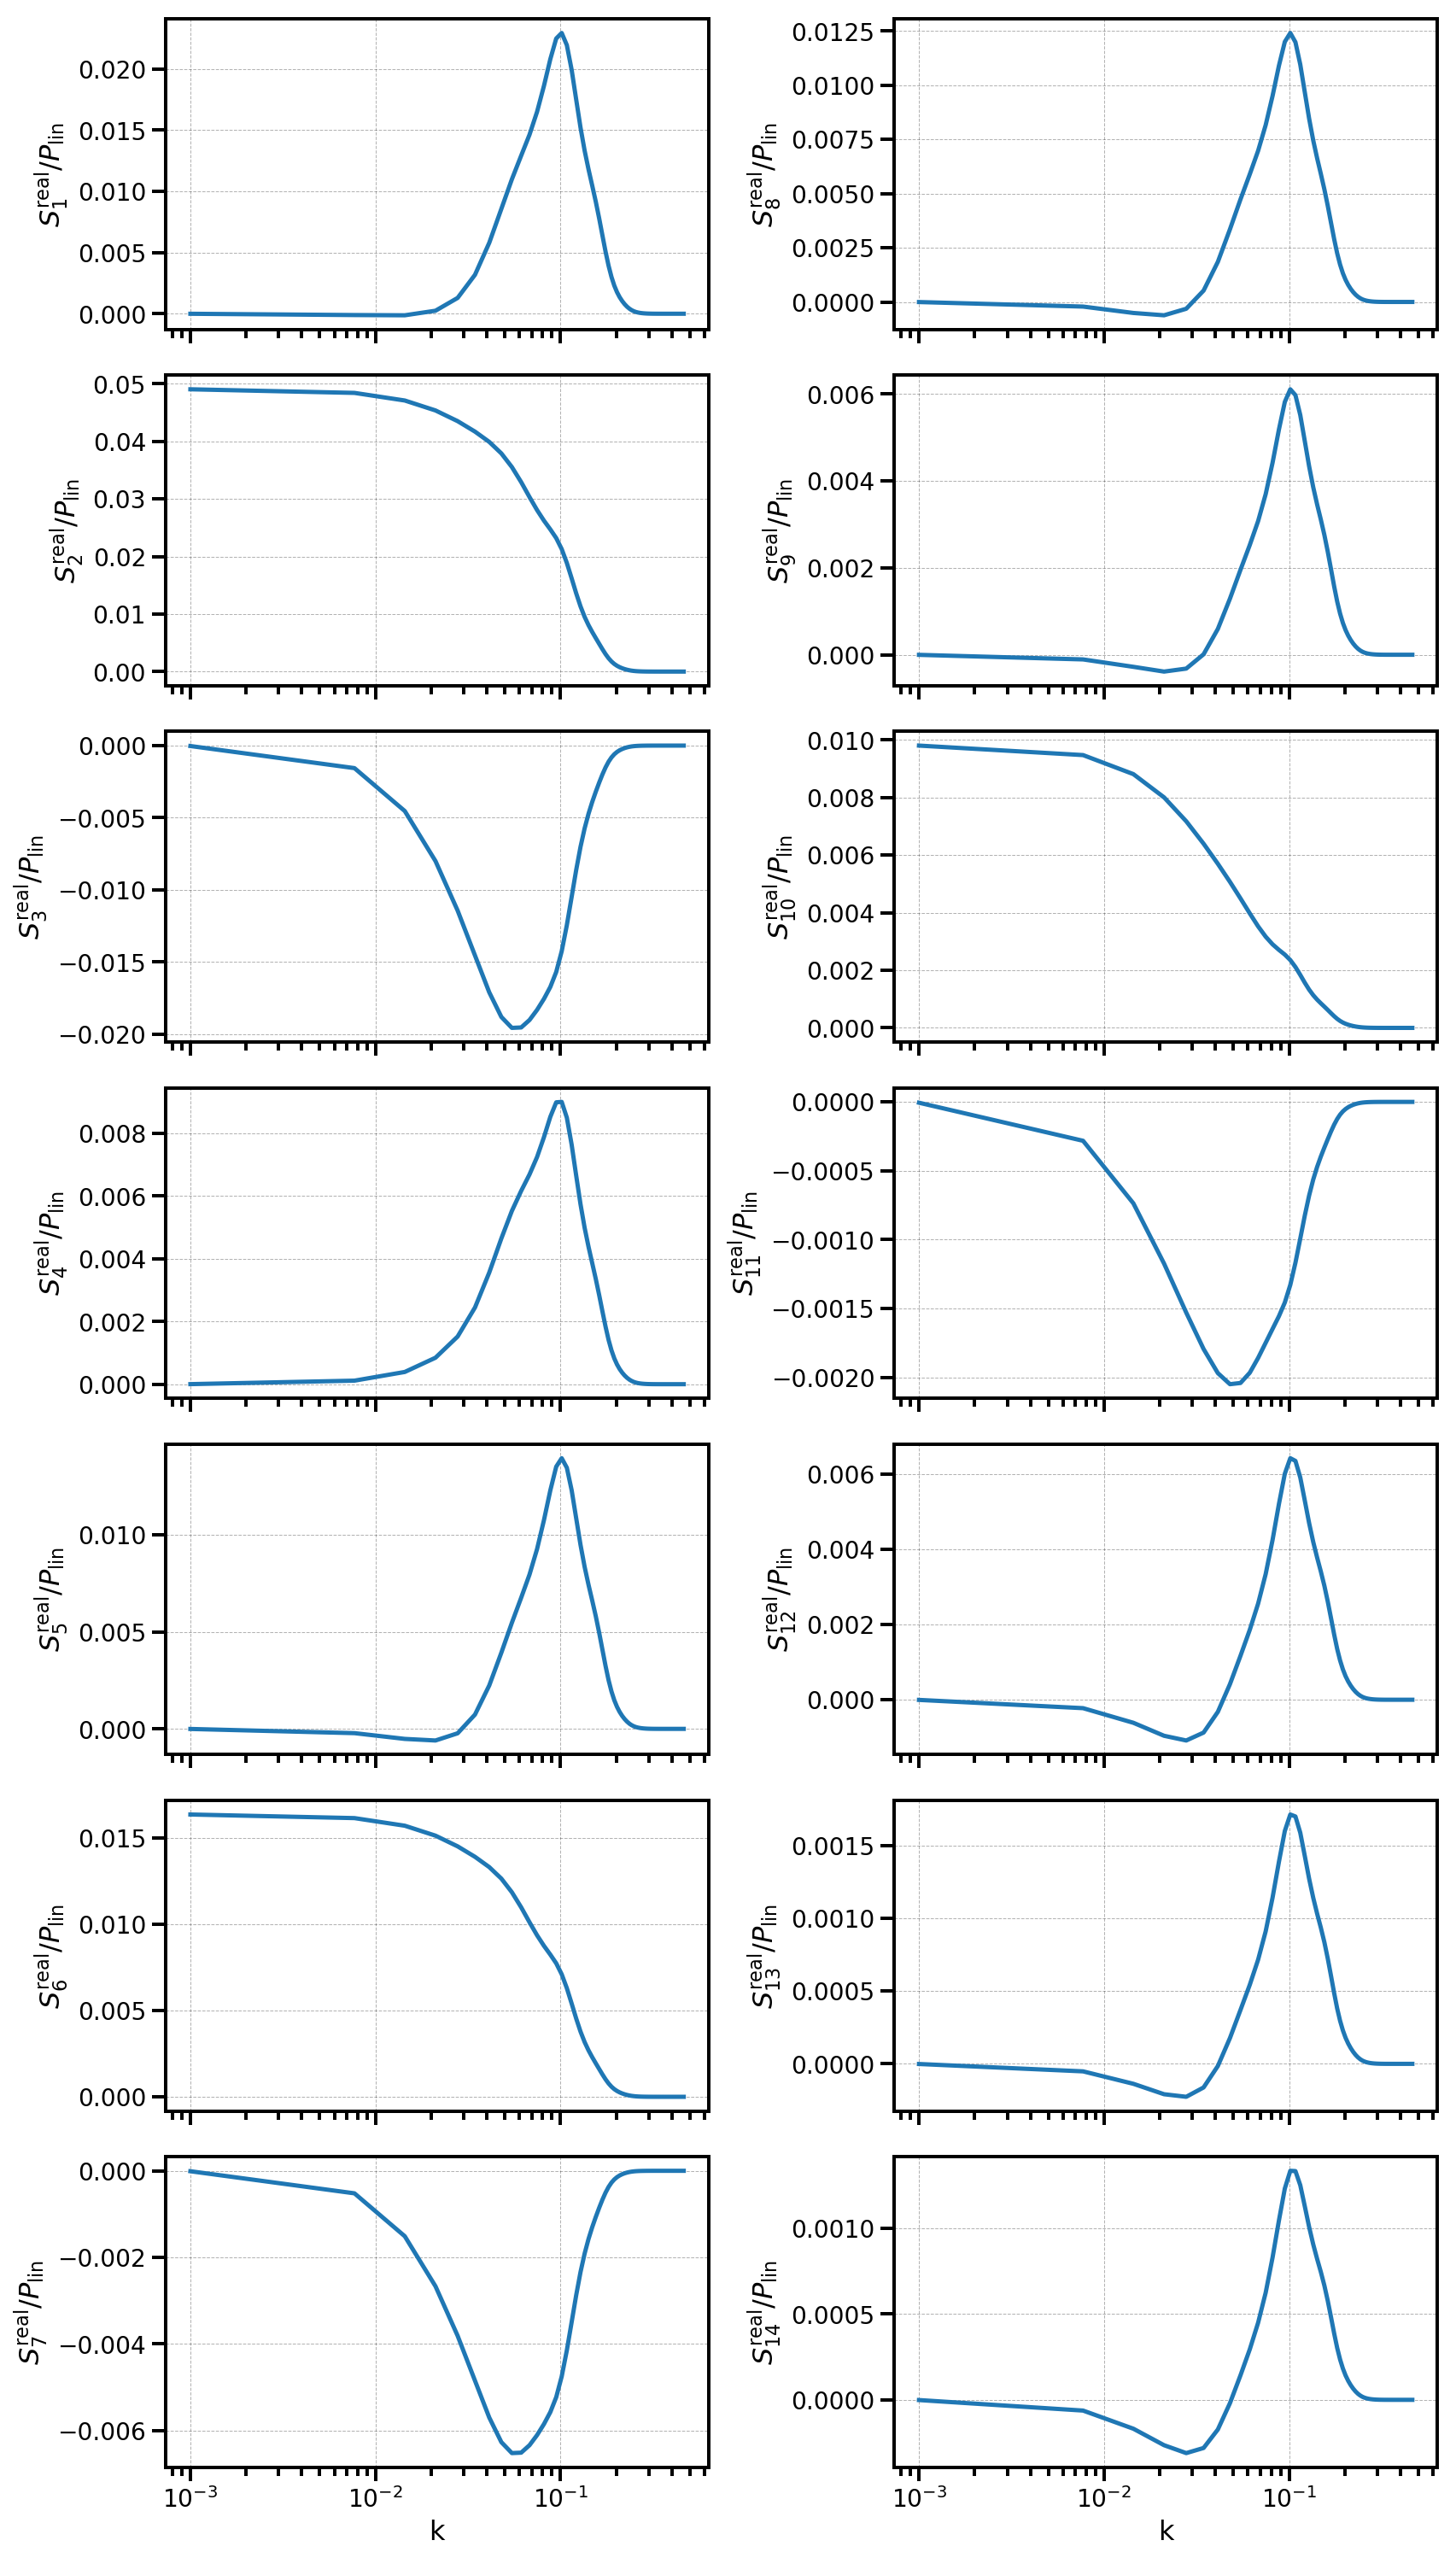

In [10]:
# PLot real space theory S_n from azadeh
fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True)
for counter, n in enumerate(range(1,15)):
    ax = axarr[counter%7,counter//7]
    ax.semilogx(Sn_real_theo['k'], Sn_real_theo['S%dp_lin'%n])
    ax.set_ylabel(r'$S^\mathregular{real}_{%d}/P_\mathregular{lin}$' % n)
axarr[6,0].set_xlabel('k')
axarr[6,1].set_xlabel('k')
plt.tight_layout()

NameError: name 'Sn_rsd_theo' is not defined

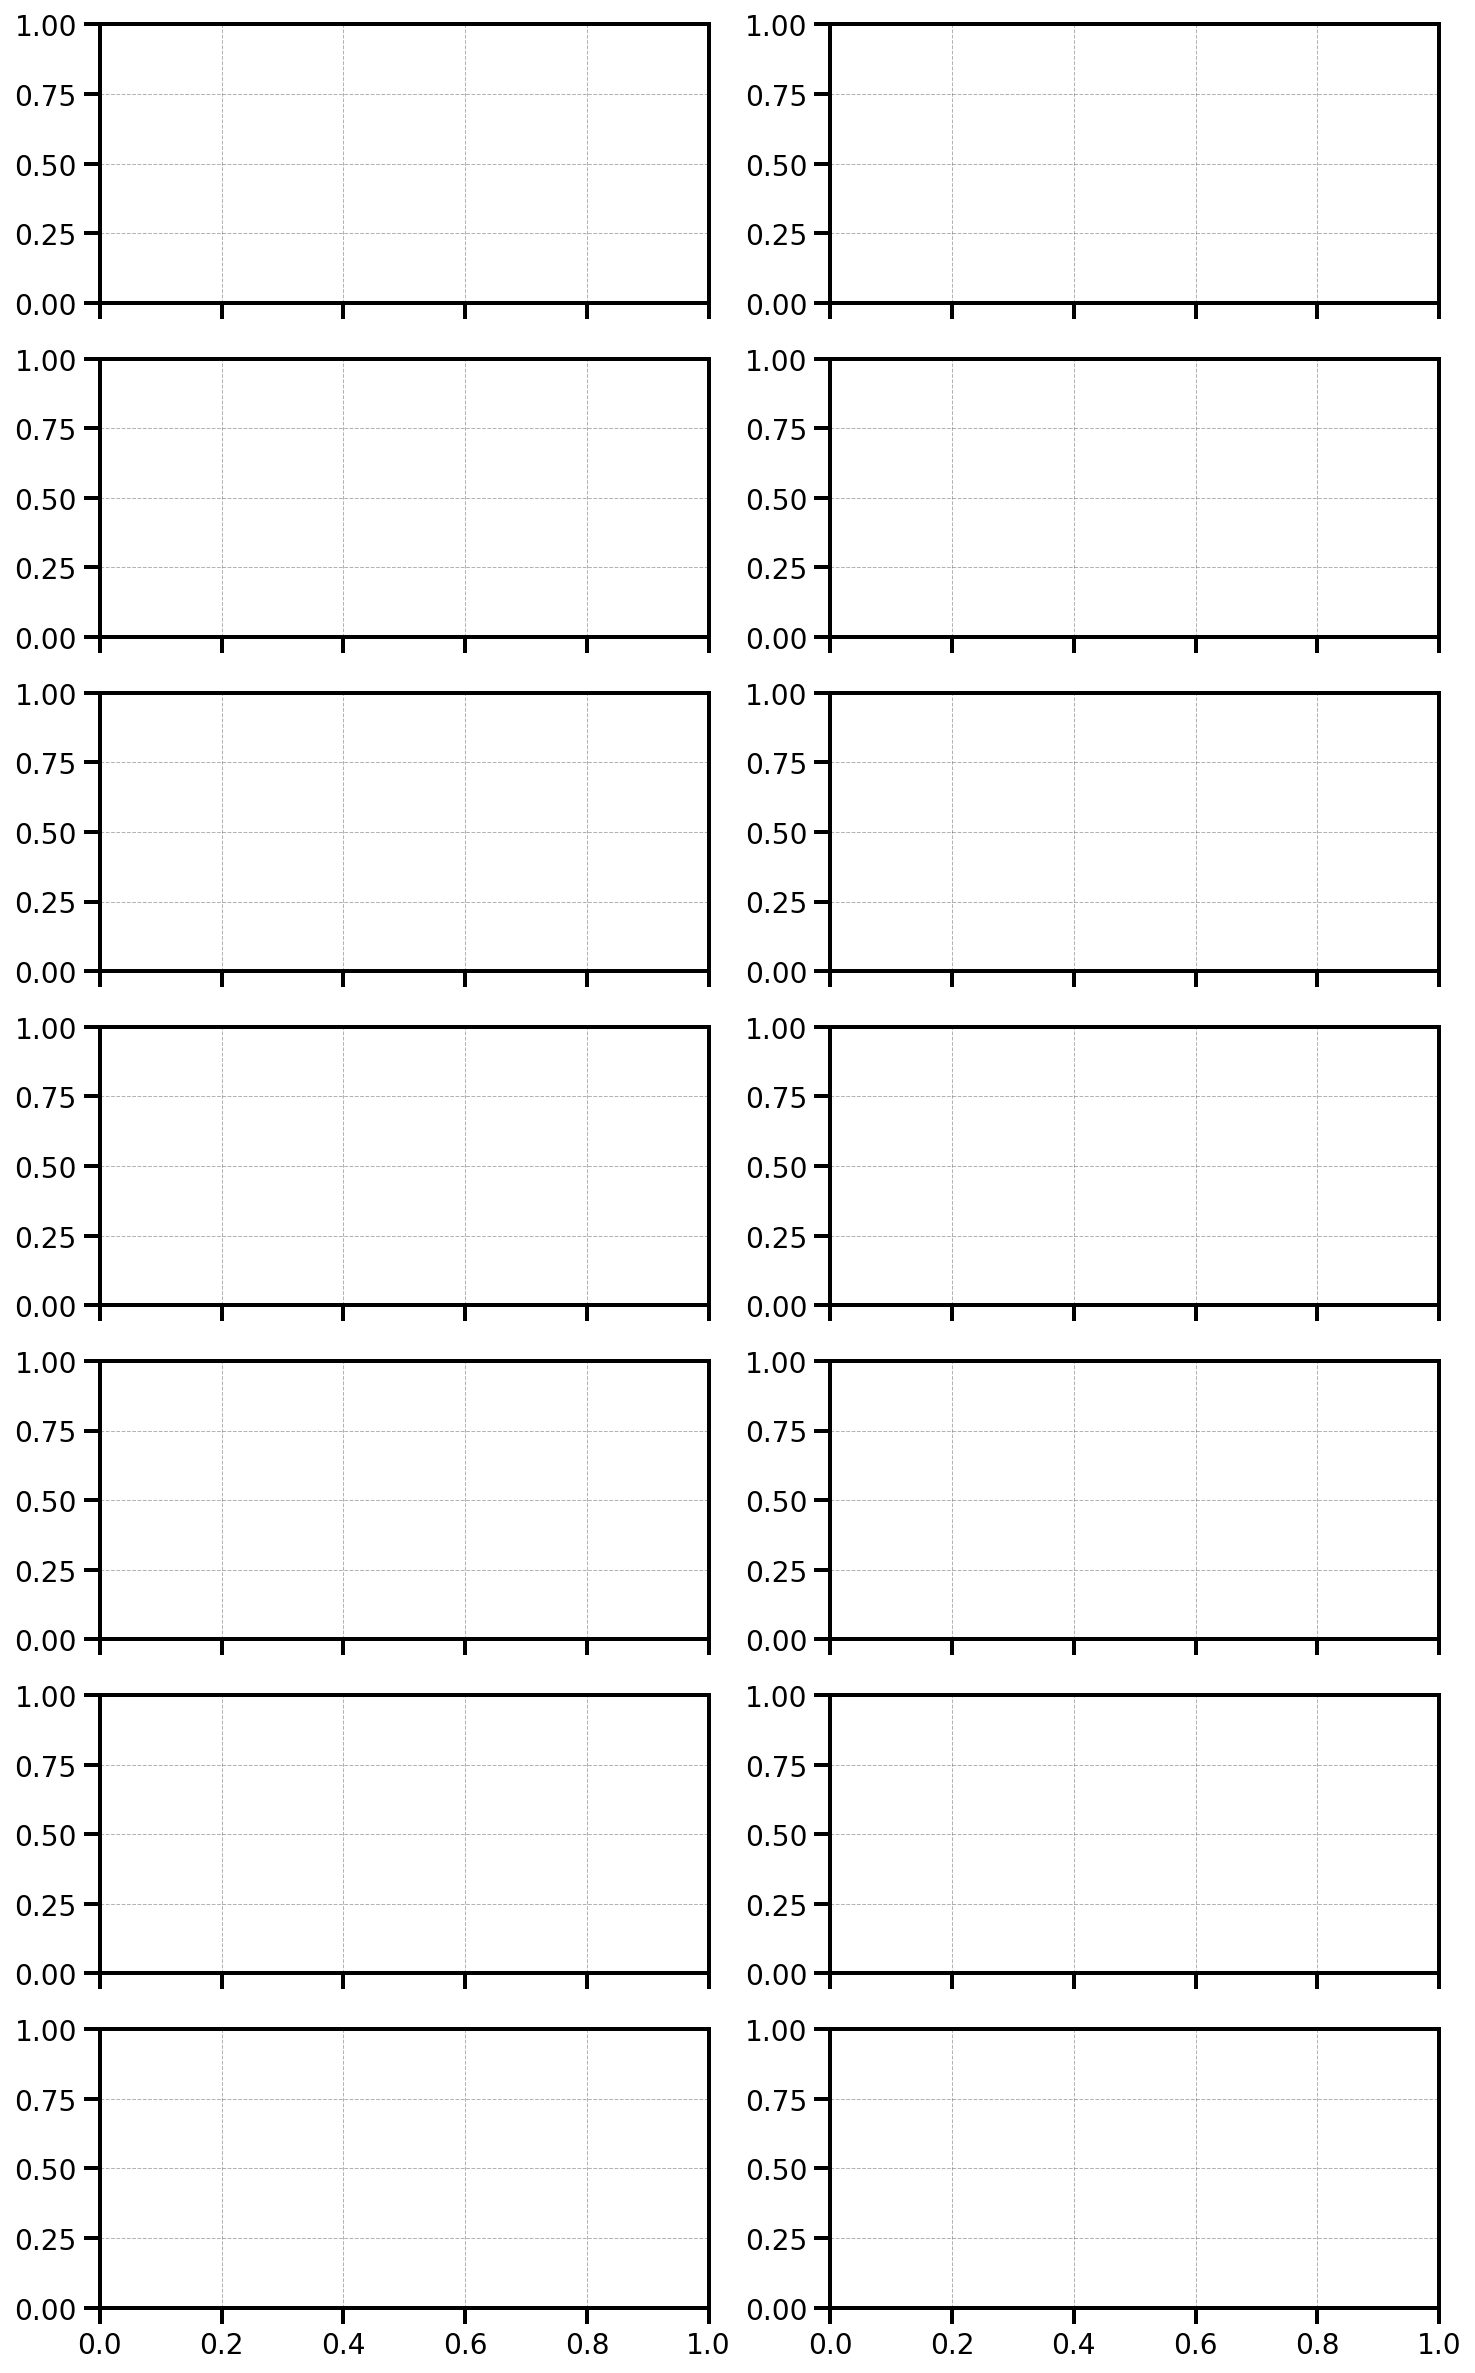

In [11]:
# PLot RSD theory S_n from azadeh
fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True)
for counter, n in enumerate(range(1,15)):
    ax = axarr[counter%7,counter//7]
    for ell in [0,2]:
        ax.semilogx(Sn_rsd_theo[(ell,)]['k'], Sn_rsd_theo[(ell,)]['S%d'%n], label=r'$\ell=%d$'%ell)
    ax.set_ylabel(r'$S^{(\ell)}_{%d}/P_\ell$' % n)
    ax.legend(loc='best')
axarr[6,0].set_xlabel('k')
axarr[6,1].set_xlabel('k')
plt.tight_layout()

## Get DM catalog in redshift space (if APPLY_RSD==True) ##

In [ ]:
#velocity_source = 'deltalin_D2'
velocity_source = 'DM_sim'

# get the catalog
#target = gal_ptchall_with_RSD
target = DM_subsample
#target = DM_D0

BoxSize = np.array([boxsize, boxsize, boxsize])

cat = target.get_catalog(keep_all_columns=True)
print(cat.attrs)


# add redshift space positions, assuming LOS is in z direction, and using DM velocity
if velocity_source == 'DM_sim':
    cat['RSDPosition'] = cat['Position'] + cat['Velocity']*cat.attrs['RSDFactor'] * LOS
elif velocity_source == 'deltalin_D2':
    raise Exception('Should not use linear velocity b/c it will not have 2nd order G2 velocity')
    mtp = ModelTargetPair(model=deltalin_D2, target=DM_subsample)
    cat['RSDPosition'] = cat['Position'].compute()
    mat = np.zeros((cat.csize,3))
    mat[:,0] = 0*mat[:,0]
    mat[:,1] = 0*mat[:,0]
    mat[:,2] = mtp.readout_model_at_target_pos()
    cat['RSDPosition'] += mat
    
print('rms RSD displacement: %g Mpc/h' % np.mean((cat['Position'].compute()-cat['RSDPosition'].compute())**2)**0.5)
print('max RSD displacement: %g Mpc/h' % np.max(np.abs(cat['Position'].compute()-cat['RSDPosition'].compute())))
    
# Get redshift space catalog
RSDcat = catalog_persist(cat, columns=['ID','PID','Position','RSDPosition','Velocity', 'log10Mvir'])
if APPLY_RSD:
    print('Applying RSD')
    RSDcat['Position'] = RSDcat['RSDPosition']
else:
    print('Not applying RSD')


In [ ]:
RSDcat.attrs

## Calculate power spectrum multipoles ##

In [ ]:
from nbodykit.lab import FFTPower, FieldMesh
def calc_power(mesh, second=None, mode='1d', k_bin_width=1.0, verbose=False, los=None, poles=None):
    BoxSize = mesh.attrs['BoxSize']
    assert BoxSize[0] == BoxSize[1]
    assert BoxSize[0] == BoxSize[2]
    boxsize = BoxSize[0]
    dk = 2.0 * np.pi / boxsize * k_bin_width
    kmin = 2.0 * np.pi / boxsize / 2.0

    if mode == '1d':
        res = FFTPower(first=mesh,
                        second=second,
                        mode=mode,
                        dk=dk,
                        kmin=kmin)
    elif mode == '2d':
        if poles is None:
            poles = [0,2,4]
        res = FFTPower(first=mesh,
                            second=second,
                            mode=mode,
                            dk=dk,
                            kmin=kmin,
                            poles=poles,
                            Nmu=5,
                            los=los)
    else:
        raise Exception("Mode not implemented: %s" % mode)

    return res

In [ ]:
## Compute power spectrum 
Nmesh = Ngrid

print('# objects: Original: %d' % (RSDcat.csize))

delta_mesh = FieldMesh(RSDcat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, 
                      window='cic', interlaced=False, compensated=False).compute()-1)
print('Mesh: ', get_cstats_string(delta_mesh.compute()))

Pdd = calc_power(delta_mesh, los=LOS, mode='2d', poles=[0,2,4])

In [ ]:
Pdd.attrs

In [ ]:
# plot power spectrum of density
plt.figure(figsize=(8,6))
kvec = Pdd.poles['k']
kpow = 1

for counter, ell in enumerate(Pdd.attrs['poles']):
    if ell>2:
        lw, alpha = 1,0.4
    else:
        lw, alpha = 3,1
    color = colors[counter]
    plt.semilogx(kvec, (kvec**kpow*Pdd.poles['power_%d'%ell].real), label=r'$\ell=%d$'%ell,
            lw=lw, alpha=alpha, color=color)
    plt.semilogx(Ptheo['k'], Ptheo['k']**kpow*Ptheo['P_%dk' % ell], label='azadeh', color=color, ls='--', lw=lw, alpha=alpha)

plt.xlabel(r'$k$')
ax = plt.gca()
ax.set_xlim((0.01,1))
ax.legend(loc='best', ncol=1, fontsize=12)
ax.set_ylabel(r'$k^%dP_\ell[\delta,\delta]$' % kpow)
plt.tight_layout()
if kpow == 1:
    plt.ylim((-500,800));
else:
    plt.ylim((-500,20000));
    


In [ ]:
# Get linear power spectrum and plot
# read Plinear at z=0
Plin_z0 = np.genfromtxt('../data/planck_camb_56106182_matterpower_z0.dat')
# convert to z=0.6
Plin = Plin_z0
Plin[:,1] *= z_rescalefac**2


interp_lnPlin_lnk = interp1d(np.log(Plin[:,0]), np.log(Plin[:,1]))
interp_Plin_k = lambda k: np.exp(interp_lnPlin_lnk(np.log(k)))

plt.subplots(figsize=(10,10))
plt.loglog(Plin[:,0], Plin[:,1])
tmpk = np.logspace(-2,1,200)
plt.loglog(tmpk, interp_Plin_k(tmpk), 'k--')

# also azadeh Plin
plt.semilogx(Ptheo['k'], Ptheo['P_link'], 'r-', lw=1)
ax = plt.gca()
ax.set_yscale('linear')

In [ ]:
# compare density power vs linear theory
plt.figure(figsize=(8,6))
kvec = Pdd.poles['k']

if APPLY_RSD:
    plt.semilogx(kvec, Pdd.poles['power_%d'%0].real / ((1. + 2.*f_log_growth/3. + f_log_growth**2/5.)*interp_Plin_k(kvec)),
                 label=r'$\ell=%d$'%0)
    plt.ylabel(r'$P_\ell[\delta,\delta]/P^\mathregular{RSD}_\mathregular{lin}$')
else:
    plt.semilogx(kvec, Pdd.poles['power_%d'%0].real / interp_Plin_k(kvec),
                 label=r'$\ell=%d$'%0)
    plt.ylabel(r'$P_\ell[\delta,\delta]/P_\mathregular{lin}$')

plt.xlabel(r'$k$')
ax = plt.gca()
ax.set_xlim((0.01,1))
ax.legend(loc='best', ncol=2, fontsize=12)
ax.set_ylim((0.5,1.5))
plt.tight_layout()

In [ ]:
(1. + 2.*f_log_growth/3. + f_log_growth**2/5.)

## Compute simple skew spectra by hand ##

In [ ]:
delta2 = FieldMesh((delta_mesh.compute())**2)
P_delta2_delta = calc_power(delta2, second=delta_mesh, los=LOS, mode='2d', poles=[0,2,4,6])

In [ ]:
# plot power spectrum 
plt.figure(figsize=(8,6))
kvec = P_delta2_delta.poles['k']
kpow = 1

for ell in P_delta2_delta.attrs['poles']:
    if ell>2:
        lw, alpha = 1,0.4
    else:
        lw, alpha = 3,1
    plt.semilogx(kvec, (kvec**kpow*P_delta2_delta.poles['power_%d'%ell].real), label=r'$\ell=%d$'%ell,
            lw=lw, alpha=alpha)

plt.xlabel(r'$k$')
ax = plt.gca()
ax.set_xlim((0.01,1))
ax.legend(loc='best', ncol=2, fontsize=12)
ax.set_ylabel(r'$k^%dP_\ell[\delta^2,\delta]$' % kpow)
plt.tight_layout()
#plt.ylim((-500,2500));



In [ ]:
# plot P_{d2,d}/P_dd
plt.figure(figsize=(8,6))
kvec = P_delta2_delta.poles['k']
kpow = 1

for ell in [0,2]:
    if ell>2:
        lw, alpha = 1,0.4
    else:
        lw, alpha = 3,1
    plt.semilogx(kvec, P_delta2_delta.poles['power_%d'%ell].real/Pdd.poles['power_%d'%ell].real,
                 label=r'$\ell=%d$'%ell,
            lw=lw, alpha=alpha)

plt.xlabel(r'$k$')
ax = plt.gca()
ax.set_xlim((0.01,1))
ax.legend(loc='best', ncol=2, fontsize=12)
ax.set_ylabel(r'$P^\ell_{\delta^2,\delta}/P^\ell_{\delta\delta}$')
plt.tight_layout()
plt.ylim((0,30));




## Get all RSD skew spectra ##

In [ ]:
from skewspec import smoothing
from skewspec.skew_spectrum import SkewSpectrumV2, QuadField, SumOfQuadFields, LinField, compute_dnm, compute_dnm_dnmprime


In [ ]:
# apply smoothing
from skewspec import smoothing
smoothers = [smoothing.GaussianSmoother(R=Rsmooth)]
delta_mesh_smoothed = FieldMesh(delta_mesh.compute(mode='real'))
for smoother in smoothers:
    delta_mesh_smoothed = smoother.apply_smoothing(delta_mesh_smoothed)
    
print('delta: ', get_cstats_string(delta_mesh.compute(mode='real')))
print('delta smoothed: ', get_cstats_string(delta_mesh_smoothed.compute(mode='real')))

In [ ]:
test_quad_field = compute_dnm_dnmprime(delta_mesh_smoothed, n=0, nprime=-2, m=[0,0,0], mprime=[0,0,1])

In [ ]:
LOS_string = 'LOS%d%d%d' % (LOS[0], LOS[1], LOS[2])
print(LOS_string)

In [ ]:
# Define skew spectra. default n=n'=0 and m=m'=[0,0,0].
s1 = SkewSpectrumV2(QuadField(composite='F2'), LOS=LOS, name='S1')
s2 = SkewSpectrumV2(QuadField(), LOS=LOS, name='S2')
s3 = SkewSpectrumV2(QuadField(composite='tidal_G2'), LOS=LOS, name='S3')
s4a = SkewSpectrumV2(QuadField(nprime=-2,mprime=2*LOS), LOS=LOS, name='S4a')
s4b = SkewSpectrumV2(QuadField(m=LOS,nprime=-2,mprime=LOS), LOS=LOS, name='S4b')
s4split = SkewSpectrumV2(
    SumOfQuadFields(quad_fields=[
        QuadField(nprime=-2, mprime=2*LOS, prefactor=1.0), 
        QuadField(m=LOS, nprime=-2, mprime=LOS, prefactor=1.0)]),
    LOS=LOS, name='S4')
s4swap = SkewSpectrumV2(
    quad=QuadField(m=LOS, nprime=-2, mprime=LOS, prefactor=1.0),
    LOS=LOS, name='S4')
s4 = SkewSpectrumV2(
    quad=QuadField(nprime=-2, mprime=LOS, mprimeprime=LOS, prefactor=1.0),
    LOS=LOS, name='S4')
# s4sep = SkewSpectrumV2(
#     quad=QuadField(nprime=-2, mprime=LOS),
#     lin=LinField(m=LOS),
#     LOS=LOS, name='S4sep')

s5 = SkewSpectrumV2(SumOfQuadFields(quad_fields=[
    QuadField(composite='F2', nprime=-2, mprime=2*LOS),
    QuadField(composite='velocity_G2_par_%s' % LOS_string)
]), LOS=LOS, name='S5')
s6 = SkewSpectrumV2(QuadField(nprime=-2, mprime=2*LOS), LOS=LOS, name='S6')
s7 = SkewSpectrumV2(QuadField(nprime=-2, mprime=2*LOS, composite='tidal_G2'), LOS=LOS, name='S7')
s8split = SkewSpectrumV2(SumOfQuadFields(quad_fields=[
    QuadField(nprime=-4, mprime=4*LOS),
    QuadField(n=-2, m=2*LOS, nprime=-2, mprime=2*LOS, prefactor=2.0),
    QuadField(m=LOS, nprime=-4, mprime=3*LOS),
    QuadField(n=-2, m=3*LOS, nprime=-2, mprime=LOS, prefactor=2.0)]), LOS=LOS, name='S8split')
fudge_fac = 1.0
s8 = SkewSpectrumV2(SumOfQuadFields(quad_fields=[
    QuadField(nprime=-4, mprime=3*LOS, mprimeprime=LOS, prefactor=fudge_fac),
    QuadField(n=-2, m=LOS, nprime=-2, mprime=2*LOS, mprimeprime=LOS, prefactor=2.0*fudge_fac)]),
    LOS=LOS, name='S8')

s9 = SkewSpectrumV2(SumOfQuadFields(quad_fields=[
    QuadField(n=-2, m=2*LOS, nprime=-2, mprime=2*LOS, composite='F2'),
    QuadField(n=-2, m=2*LOS, composite='velocity_G2_par_%s' % LOS_string, prefactor=2.0)]),
    LOS=LOS, name='S9')
s10 = SkewSpectrumV2(QuadField(n=-2, m=2*LOS, nprime=-2, mprime=2*LOS), LOS=LOS, name='S10')
s11 = SkewSpectrumV2(QuadField(n=-2, m=2*LOS, nprime=-2, mprime=2*LOS, composite='tidal_G2'), LOS=LOS, name='S11')
if True:
    # correct S12
    s12 = SkewSpectrumV2(SumOfQuadFields(quad_fields=[
        QuadField(n=-4, m=4*LOS, nprime=-2, mprime=LOS, mprimeprime=LOS),
        QuadField(n=-2, m=2*LOS, nprime=-4, mprime=3*LOS, mprimeprime=LOS, prefactor=2.0)]),
        LOS=LOS, name='S12')
else:
    # play woth S12
    s12 = SkewSpectrumV2(SumOfQuadFields(quad_fields=[
        QuadField(n=-4, m=4*LOS, nprime=-2, mprime=LOS, mprimeprime=2*LOS),
        QuadField(n=-2, m=2*LOS, nprime=-4, mprime=3*LOS, mprimeprime=2*LOS, prefactor=2.0)]),
        LOS=LOS, name='S12')
s13 = SkewSpectrumV2(
    QuadField(n=-2, m=2*LOS, nprime=-2, mprime=2*LOS, composite='velocity_G2_par_%s' % LOS_string),
    LOS=LOS, name='S13')
if True:
    # correct S14
    s14 = SkewSpectrumV2(
        QuadField(n=-4, m=3*LOS, nprime=-4, mprime=4*LOS, mprimeprime=LOS),
        LOS=LOS, name='S14')
else:
    # play with S14
    s14 = SkewSpectrumV2(
        QuadField(n=-4, m=3*LOS, nprime=-4, mprime=4*LOS, mprimeprime=2*LOS),
        LOS=LOS, name='S14')

s4test = SkewSpectrumV2(
    QuadField(mprimeprime=LOS), LOS=LOS, name='S4')

In [ ]:
outdir = '../data/Pskew_sims/00000%d-01536-%.1f-wig/R%.1f_Ng%d_RSD%d/' % (sim_seed, boxsize, Rsmooth,Nmesh,int(APPLY_RSD))
power_kwargs={'mode': '2d', 'poles':[0,2]}
#skew_spectra = [s1,s2, s3, s4, s5,s6, s7, s8, s9, s10, s11, s12, s13, s14]
skew_spectra = [s4test]
#skew_spectra = [S4, S4swap, S4split, S4a, S4b, S8, S12, S14]


# compute and store skew spectra
if not os.path.exists(outdir):
    os.makedirs(outdir)
for skew_spec in skew_spectra:
    # compute and store in skew_spec.Pskew
    skew_spec.compute_from_mesh(mesh=delta_mesh_smoothed, third_mesh=delta_mesh, power_kwargs=power_kwargs)



In [ ]:
# store in individual files
if False:
    for skew_spec in skew_spectra:
        # store as json
        fname = os.path.join(outdir, skew_spec.name+'.json')
        skew_spec.Pskew.save(fname)
        print('Wrote %s' % fname)

        # store as plain text
        fname = os.path.join(outdir, skew_spec.name+'.txt')
        skew_spec.save_plaintext(fname)
        print('Wrote %s' % fname)
    
# store all in one file for each multipole
for ell in skew_spec.Pskew.attrs['poles']:
    mydtype = [('k', 'f8')]
    for skew_spec in skew_spectra:
        mydtype.append((skew_spec.name, 'f8'))
    arr = np.empty(shape=skew_spec.Pskew.poles['k'].shape, dtype=mydtype)
    arr['k'] = skew_spec.Pskew.poles['k']
    for skew_spec in skew_spectra:
        arr[skew_spec.name] = skew_spec.Pskew.poles['power_%d'%ell].real
    fname = os.path.join(outdir, 'Sn_ell%d.txt'%ell)
    header = 'Columns: ' + str(arr.dtype.names)
    np.savetxt(fname, arr, header=header)
    print('Wrote %s' % fname)

In [ ]:
# plot Pskew/P_dd
fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True)
kvec = Pdd.poles['k']
ww = np.where(kvec<=1.0)[0]
for counter,skew_spec in enumerate(skew_spectra):
    ax = axarr[counter%7,counter//7]

    for ell in [0]:        
        color = colors[ell]
        
        # plot measurements
        if APPLY_RSD:
            # divide by measured P_l
            ax.semilogx(kvec[ww], skew_spec.Pskew.poles['power_%d'%ell].real[ww]/Pdd.poles['power_%d'%ell].real[ww], marker='o', lw=0,
                         label=r'$\ell=%d$'%ell, color=color, markersize=5)

        
        # divide by theory P_l
        if ell==0:
            if APPLY_RSD:
                ax.semilogx(kvec[ww], skew_spec.Pskew.poles['power_%d'%ell].real[ww]/interp_Ptheo_k_P0(kvec[ww]), marker='d', lw=0,
                         label=r'$\ell=%d$'%ell, color='r', markersize=5)
            else:
                ax.semilogx(kvec[ww], skew_spec.Pskew.poles['power_%d'%ell].real[ww]/interp_Ptheo_k_Plin(kvec[ww]), marker='d', lw=0,
                         label=r'$\ell=%d$'%ell, color='r', markersize=5)
        
        # plot theory skew spectra 
        if APPLY_RSD:
            # S_n/Pl
            if skew_spec.name in Sn_rsd_theo[(ell,)].dtype.names:
                ax.semilogx(Sn_rsd_theo[(ell,)]['k'], Sn_rsd_theo[(ell,)][skew_spec.name], label='theo', color=color,
                    lw=1)
        else:
            # S_n/Plin
            if skew_spec.name+'p_lin' in Sn_real_theo.dtype.names:
                ax.semilogx(Sn_real_theo['k'], Sn_real_theo[skew_spec.name+'p_lin'], label='theo', color=color,
                    lw=1)

    # cosmetics
    ax.set_xlim((0.01,1))
    ax.legend(loc='best', ncol=1, fontsize=12)
    if APPLY_RSD:
        ax.set_ylabel(r'$%s/P^\ell_{\delta\delta}$' % skew_spec.name)
    else:
        ax.set_ylabel(r'$%s/P_\mathregular{lin}$' % skew_spec.name)
axarr[6,0].set_xlabel(r'$k$')
axarr[6,1].set_xlabel(r'$k$')
plt.tight_layout()

fname = '../pdf/skewV2_DM_L%g_R%.1f_Ng%d_RSD%d.pdf' % (boxsize, Rsmooth,Nmesh,int(APPLY_RSD))
plt.savefig(fname)
print('Made %s' % fname)

In [ ]:
2.*np.pi/1500.

In [ ]:
str(skew_spec.Pskew.attrs)